# Make Panda Dataset

In [1]:
import cv2
from glob import glob
import numpy as np
import os
import json
import matplotlib.pyplot as plt
%matplotlib inline
import cv2

In [2]:
VIDEO_DIR = './videos'
IMAGE_DIR = './images'

In [4]:
class Pandataset():

    def __init__(self, video_dir, image_dir, samples_per_video=10):
        self.panda_videos = sorted(glob(video_dir+'/*.mp4'))
        self.image_dir = image_dir
        self.image_idx = 0
        self.samples_per_video = samples_per_video
        self.num_of_videos = len(self.panda_videos)
        
    def _fetch_frame_from_video(self, video_idx, phase):
        video_file = self.panda_videos[video_idx]
        print(phase, video_file)
        video_cap = cv2.VideoCapture(video_file)
        total_frames = int(video_cap.get(cv2.CAP_PROP_FRAME_COUNT))
        frame_idxs = np.random.choice(total_frames, self.samples_per_video)
        for frame_idx in frame_idxs:            
            video_cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
            success, image = video_cap.read()
            if success:
                image_dir = os.path.join(self.image_dir, phase)
                if not os.path.exists(image_dir):
                    os.makedirs(image_dir)
                cv2.imwrite('{}/{:04d}.jpg'.format(image_dir, self.image_idx), image)
                self.image_idx += 1
            else:
                print('[*] UNSECCESS SAMPLING in ', video_file)
            
    
    def generate(self):
        for idx in range(len(self.panda_videos)):
            if idx < 0.8 * self.num_of_videos:
                self._fetch_frame_from_video(idx, 'train')
            elif idx < self.num_of_videos - 1:
                self._fetch_frame_from_video(idx, 'val')
            else:
                self._fetch_frame_from_video(idx, 'test')
    

In [5]:
pandataset = Pandataset(VIDEO_DIR, IMAGE_DIR)

In [6]:
pandataset.generate()

train ./videos/01-cute_alert_giant_panda_cuddles_with_keeper_during_shower_time.mp4
train ./videos/02-panda_cub_and_nannys_war.mp4
train ./videos/03-Raising_cute_Pandas_Its_complicated.mp4
train ./videos/04-Pandas_in_Tokyo.mp4
train ./videos/05-Pandas_in_Taipei.mp4
train ./videos/06-from_iPanda.mp4
train ./videos/07-the_first_year_of_mei_lun_and_mei_huan.mp4
train ./videos/08-the_giant_panda_cubs_first_day_outside.mp4
train ./videos/09-panda_sighting_in_the_wild.mp4
train ./videos/10-cute_pandas_playing_on_the_silde.mp4
train ./videos/11-panda_sisters.mp4
train ./videos/12-nanny_stop_working.mp4
val ./videos/13-panda_in_office.mp4
val ./videos/14-baby_and_mom.mp4
test ./videos/15-top10funnyandcutestpandavideo.mp4


# Unify some differences between VIA labeling Tool and COCO

In [19]:
def transfer_image_id_dtype(annotation_file, output_annotation_file):
    with open(annotation_file, 'r') as f:
        data_str = f.readline().strip()
    data = json.loads(data_str)
    annotations = data['annotations']
    for annotation in annotations:
        # change str to int
        annotation['image_id'] = int(annotation['image_id'])   
        # change [x1,x2,y1,y2] to [[x1,x2],[y1,y2]]
        segementation = annotation['segmentation']                  
        n = len(segementation)
        num_of_point = n // 2
        xs = segementation[:num_of_point]
        ys = segementation[num_of_point:]
        segementation = [xs, ys]
        annotation['segmentation'] = segementation
    data['annotations'] = annotations    
    with open(output_annotation_file, 'w') as f:
        json.dump(data, f)
"""
for phase in ["train", "val"]:
    anno = "panda_coco/annotations/via_panda_{}.json".format(phase)
    output = "panda_coco/annotations/panda_{}.json".format(phase)
    transfer_image_id_dtype(anno)
"""

# Check Padataset

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


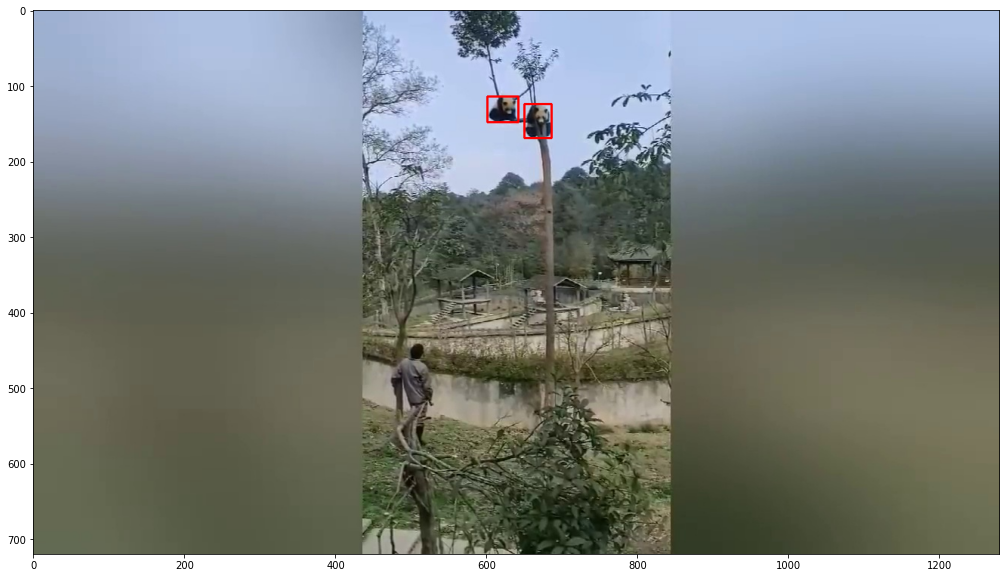

In [3]:
from pycocotools.coco import COCO

def draw_coco_box(image, coco_box):
    start_point = tuple(coco_box[:2])
    end_point = tuple([coco_box[0]+coco_box[2], coco_box[1]+coco_box[3]])
    image = cv2.rectangle(image, start_point, end_point, (255,0,0), 2)
    return image

anno = "panda_coco/annotations/panda_val.json"
coco = COCO(anno)

image_id = 16
img = coco.loadImgs(image_id)[0]
image = cv2.imread(os.path.join('panda_coco', 'val', img['file_name']))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
annIds = coco.getAnnIds(imgIds=[image_id])
anns = coco.loadAnns(annIds)
for ann in anns:
    coco_box = ann['bbox']
    image = draw_coco_box(image, coco_box)
plt.figure(figsize=(20,10))
plt.imshow(image)

# Model Settings

In [4]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import numpy as np
import cv2
import os

import matplotlib.pyplot as plt
%matplotlib inline

import random

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog


In [5]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("panda_train", {}, "panda_coco/annotations/panda_train.json", "panda_coco/train")
register_coco_instances("panda_val", {}, "panda_coco/annotations/panda_val.json", "panda_coco/val")

In [6]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_C4_1x.yaml"))
cfg.DATASETS.TRAIN = ("panda_train",)
cfg.DATASETS.TEST = ("panda_val",)
cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_C4_1x.yaml")  # Let training initialize from model zoo
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1               # IMPORTANT HERE!  1 for panda
cfg.MODEL.ROI_HEADS.BATCH_SIZE_FOR_IMAGE = 128

cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 500    # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.INPUT.MAX_SIZE_TEST = 1280
cfg.INPUT.MAX_SIZE_TRAIN = 1280

In [7]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[04/17 15:31:12 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): ResNet(
    (stem): BasicStem(
      (conv1): Conv2d(
        3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
      )
    )
    (res2): Sequential(
      (0): BottleneckBlock(
        (shortcut): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
        )
        (conv1): Conv2d(
          64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv2): Conv2d(
          64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv3): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
 

[04/17 15:31:12 d2.data.datasets.coco]: Loaded 120 images in COCO format from panda_coco/annotations/panda_train.json
WARNING [04/17 15:31:12 d2.data.datasets.coco]: Filtered out 77 instances without valid segmentation. There might be issues in your dataset generation process.
[04/17 15:31:12 d2.data.build]: Removed 55 images with no usable annotations. 65 images left.
[04/17 15:31:12 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|   panda    | 89           |
|            |              |
[04/17 15:31:12 d2.data.common]: Serializing 65 elements to byte tensors and concatenating them all ...
[04/17 15:31:12 d2.data.common]: Serialized dataset takes 0.03 MiB
[04/17 15:31:12 d2.data.detection_utils]: TransformGens used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1280, sample_style='choice'), RandomFlip()]
[04/17 15:31:12 d2.data.build]: Using training sampler Tra

'roi_heads.box_predictor.cls_score.weight' has shape (81, 2048) in the checkpoint but (2, 2048) in the model! Skipped.
'roi_heads.box_predictor.cls_score.bias' has shape (81,) in the checkpoint but (2,) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.weight' has shape (320, 2048) in the checkpoint but (4, 2048) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.bias' has shape (320,) in the checkpoint but (4,) in the model! Skipped.
'roi_heads.mask_head.predictor.weight' has shape (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in the model! Skipped.
'roi_heads.mask_head.predictor.bias' has shape (80,) in the checkpoint but (1,) in the model! Skipped.


[04/17 15:31:12 d2.engine.train_loop]: Starting training from iteration 0
[04/17 15:31:33 d2.utils.events]:  eta: 0:08:08  iter: 19  total_loss: 1.754  loss_cls: 0.690  loss_box_reg: 0.151  loss_mask: 0.692  loss_rpn_cls: 0.108  loss_rpn_loc: 0.065  time: 1.0271  data_time: 0.0145  lr: 0.000005  max_mem: 4942M
[04/17 15:31:53 d2.utils.events]:  eta: 0:07:51  iter: 39  total_loss: 1.654  loss_cls: 0.607  loss_box_reg: 0.196  loss_mask: 0.687  loss_rpn_cls: 0.086  loss_rpn_loc: 0.055  time: 1.0273  data_time: 0.0032  lr: 0.000010  max_mem: 4942M
[04/17 15:32:14 d2.utils.events]:  eta: 0:07:33  iter: 59  total_loss: 1.557  loss_cls: 0.460  loss_box_reg: 0.188  loss_mask: 0.680  loss_rpn_cls: 0.132  loss_rpn_loc: 0.060  time: 1.0296  data_time: 0.0029  lr: 0.000015  max_mem: 4942M
[04/17 15:32:34 d2.utils.events]:  eta: 0:07:11  iter: 79  total_loss: 1.416  loss_cls: 0.327  loss_box_reg: 0.180  loss_mask: 0.670  loss_rpn_cls: 0.135  loss_rpn_loc: 0.067  time: 1.0281  data_time: 0.0029  lr:

In [8]:
%load_ext tensorboard
%tensorboard --logdir output

Reusing TensorBoard on port 6006 (pid 25945), started 0:46:25 ago. (Use '!kill 25945' to kill it.)

# Inference & Evaluation trained model

## Inference

In [12]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7
cfg.DATASETS.TEST = ("panda_val",)
predictor = DefaultPredictor(cfg)

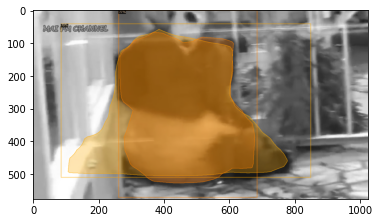

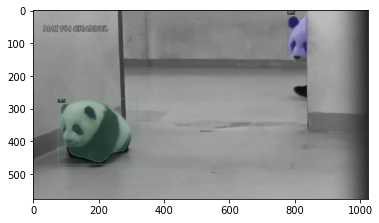

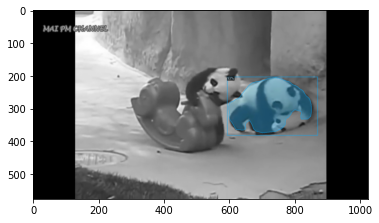

In [14]:
from detectron2.utils.visualizer import ColorMode
image_dirs = glob('./panda_coco/test/*.jpg')
metadata = MetadataCatalog.get("panda_train")
for i, image_dir in enumerate(random.sample(image_dirs, 3)):
    im = cv2.imread(image_dir)
    outputs = predictor(im)
    v = Visualizer(im[:,:,::-1],
                  metadata=metadata,
                  scale=0.8,
                  instance_mode=ColorMode.IMAGE_BW)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    image = v.get_image()[:,:,::-1]
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(i)
    plt.imshow(image)
    plt.show()

## Evaluate

In [15]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("panda_val", cfg, False, output_dir='./output')
val_loader = build_detection_test_loader(cfg, "panda_val")
inference_on_dataset(trainer.model, val_loader, evaluator)

[04/17 15:40:25 d2.data.datasets.coco]: Loaded 20 images in COCO format from panda_coco/annotations/panda_val.json
WARNING [04/17 15:40:25 d2.data.datasets.coco]: Filtered out 12 instances without valid segmentation. There might be issues in your dataset generation process.
[04/17 15:40:25 d2.data.common]: Serializing 20 elements to byte tensors and concatenating them all ...
[04/17 15:40:25 d2.data.common]: Serialized dataset takes 0.01 MiB
[04/17 15:40:25 d2.evaluation.evaluator]: Start inference on 20 images
[04/17 15:40:27 d2.evaluation.evaluator]: Inference done 11/20. 0.1520 s / img. ETA=0:00:01
[04/17 15:40:29 d2.evaluation.evaluator]: Total inference time: 0:00:03.547858 (0.236524 s / img per device, on 1 devices)
[04/17 15:40:29 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:02 (0.184474 s / img per device, on 1 devices)
[04/17 15:40:29 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[04/17 15:40:29 d2.evaluation.coco_evaluation]: Savin

OrderedDict([('bbox',
              {'AP': 28.47439760688417,
               'AP50': 56.204650369806565,
               'AP75': 24.371134866381798,
               'APs': nan,
               'APm': 6.639833418557803,
               'APl': 35.78105439442956}),
             ('segm',
              {'AP': 8.893028866398073,
               'AP50': 32.62030114849173,
               'AP75': 4.144093372447912,
               'APs': nan,
               'APm': 0.0,
               'APl': 11.477521787866237})])